# Read Encoder from Motor via Serial

In [16]:
try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig
from matplotlib import gridspec
from matplotlib import rcParams
rcParams["font.serif"] = "cmr14"
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 5.0]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.autolayout"] = True
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
# use with Motor_PWM_Enc.ino
# 0.5 to 6 Hz linear chirp in 10s  N = 100000

import os
def findteensy():
    ports = os.listdir("/dev/")
    cports = [f for f in ports if f.startswith("cu.usb")]
    try: 
        port = "/dev/"+cports[0]
        print(port)
        return port, True
    except:
        print("No Teensy")
        return "none found", False

port, status = findteensy()
print("Teensy found at ",port)


No Teensy
Teensy found at  none found


In [17]:
# Initialize 
N = 10000

In [20]:
# See if Teensy present or load data if that exists
if status:
    t = []
    RPM = []
    V1 = []
    V5 =[]
    Encoder = []

    ser = serial.Serial(port)
    ser.flushInput()

    # sum will treat Boolean True as a 1, False as a 0
    n = sum(os.path.isfile(name) for name in os.listdir('.'))
    file_name = "Encoder_data_%s.csv" % n 
    print("Storing recorded data in",file_name)

    for jj in np.arange(N):
        ser_byte = ser.readline()
        decoded_bytes = ser_byte.decode('ascii').split(',')
        dt = float(decoded_bytes[0])
        dRPM = float(decoded_bytes[1])
        dV1 = float(decoded_bytes[2])
        dV5 = float(decoded_bytes[3])
        dEncoder = float(decoded_bytes[4])
        t.append(dt)
        RPM.append(dRPM)
        V1.append(dV1)
        V5.append(dV5)
        Encoder.append(dEncoder)

        if (jj % 100 == 0):
            print(jj/N, end=', ')

        with open(file_name, "a+", newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerow([dt, dRPM, dV1, dV5, dEncoder])
                   
else:
    try:
        t = [] # re-initialize since might have been touched by the previous steps
        RPM = []
        V1 = []
        V5 =[]
        Encoder = []

        with open("./data/Encoder_data_20.XXcsv", 'r') as file:
            reader = csv.reader(file)   
            for row in reader:
                if len(row) >= 4:
                    t.append(float(row[0]))
                    RPM.append(float(row[1]))
                    V1.append(float(row[2]))
                    V5.append(float(row[3]))
                    if len(row) == 5:
                        Encoder.append(float(row[4]))
                    else:
                        Encoder.append(float(0.0))

        print("Loaded local recorded data")

    except Exception as e1: 
        print(e1)
        t = [] # re-initialize since might have been touched by the previous steps
        RPM = []
        V1 = []
        V5 =[]
        Encoder = []
        url = 'https://raw.githubusercontent.com/JonHowMIT/Signals_and_Systems/main/data/Encoder_data_20.csv'
        download = requests.get(url).text.split("\r\n")
        for line in download:
            row = line.strip().split(',')
            if len(row) >= 4:
                t.append(float(row[0]))
                RPM.append(float(row[1]))
                V1.append(float(row[2]))
                V5.append(float(row[3]))
                if len(row) == 5:
                    Encoder.append(float(row[4]))
                else:
                    Encoder.append(float(0.0))

        print("Loaded remote recorded data")

t = np.array(t)
t -= t[0]    

[Errno 2] No such file or directory: './data/Encoder_data_20.XXcsv'
Loaded remote recorded data


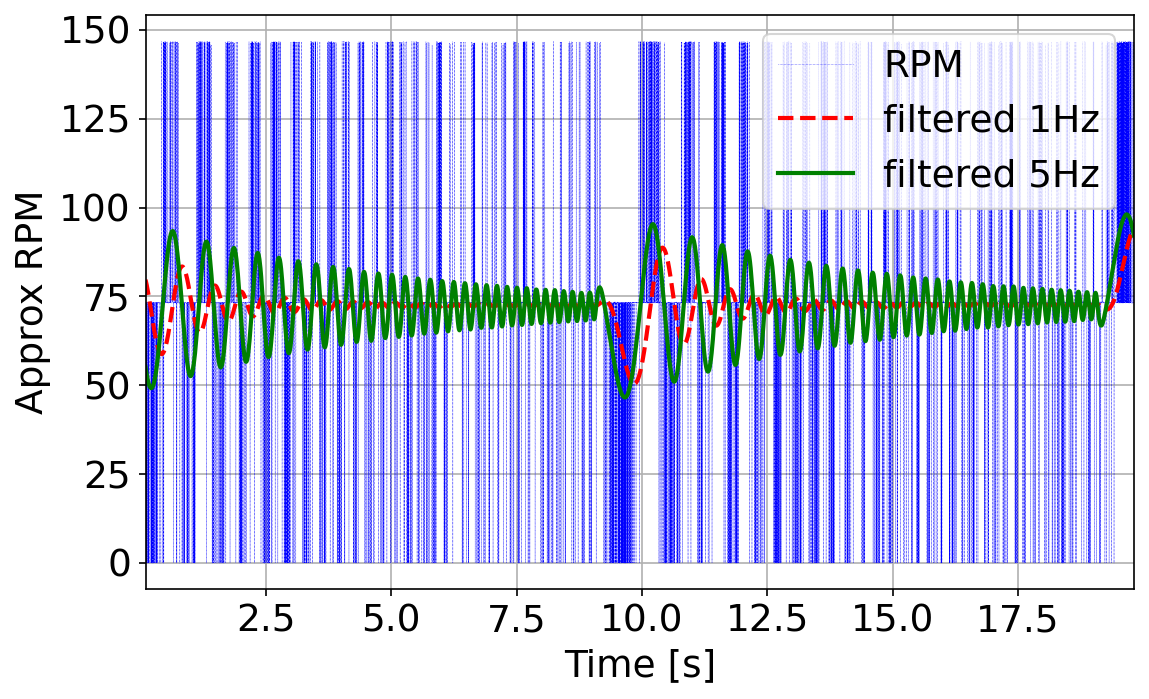

In [21]:
# parts to plot
Nlow = 50
Nhigh = N-100 

fig, ax = plt.subplots()
ax.plot(t[Nlow:Nhigh],RPM[Nlow:Nhigh],'b:',lw=0.25)
ax.plot(t[Nlow:Nhigh],V1[Nlow:Nhigh],'r--')
ax.plot(t[Nlow:Nhigh],V5[Nlow:Nhigh],'g-')
ax.set_xlim(t[Nlow], t[Nhigh])
#ax.set_ylim(-25, 175)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Approx RPM')
plt.legend(['RPM','filtered 1Hz','filtered 5Hz'])
plt.grid(True)
plt.show()
fig.savefig('./data/response1.png', dpi=300)


## Plot Raw encoder rate compared to filtered values

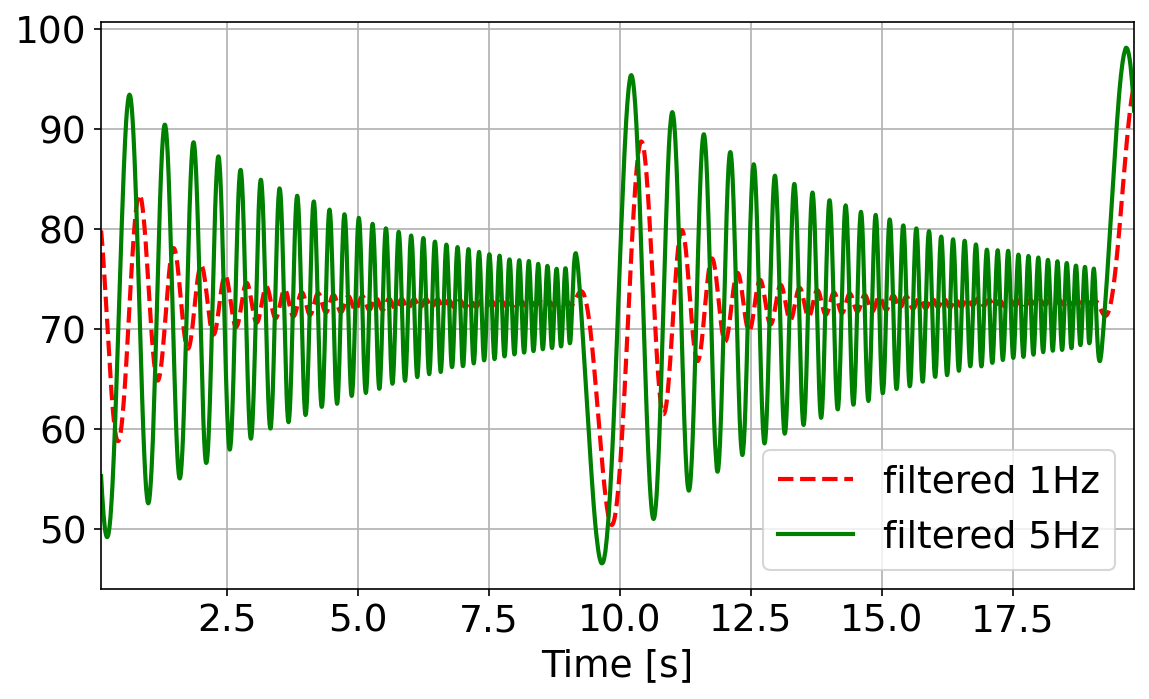

In [22]:
fig, ax = plt.subplots()
ax.plot(t,V1,'r--')
ax.plot(t,V5,'g-')
ax.set_xlim(t[Nlow], t[Nhigh])
#ax.set_ylim(40, 120)
plt.legend(['filtered 1Hz','filtered 5Hz'])
ax.set_xlabel('Time [s]')
plt.grid(True)
plt.show()
fig.savefig('./data/response2.png', dpi=300)


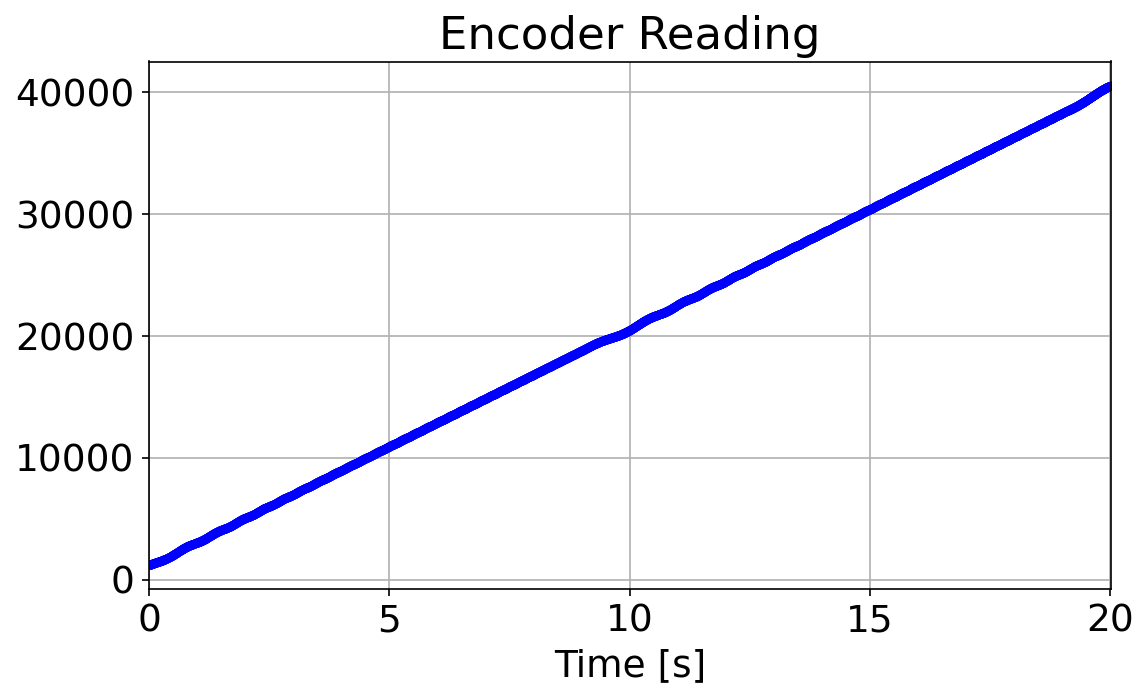

In [23]:
# Check Encoder
fig, ax = plt.subplots()
ax.plot(t,Encoder,'b.')
#ax.set_ylim(4000, 4400)
#ax.set_xlim(t[Nlow], t[Nhigh])
ax.set_xlabel('Time [s]')
plt.title('Encoder Reading')
plt.grid(True)
plt.show()
fig.savefig('./data/encoder.png', dpi=300)


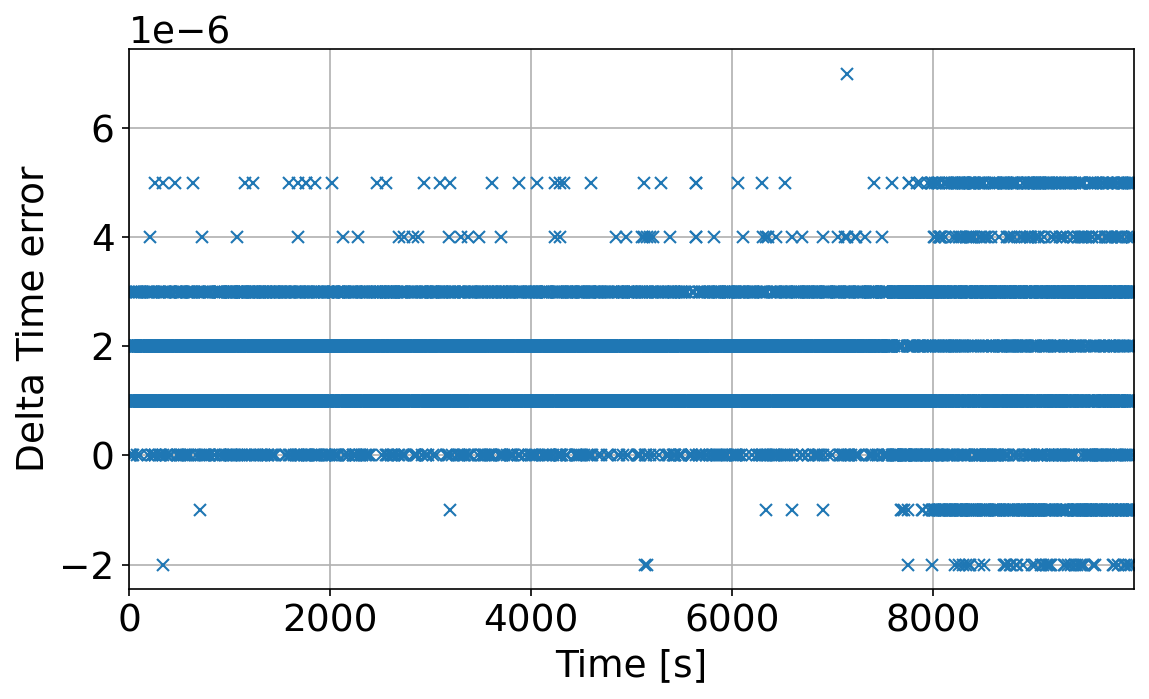

In [24]:
# check timing
printtime = 2000e-6 # in teensy code
fig, ax = plt.subplots()
plt.plot(np.diff(t) - printtime,'x')
ax.set_ylabel('Delta Time error')
ax.set_xlabel('Time [s]')
plt.show()
fig.savefig('./data/timing.png', dpi=300)
